In [ ]:
!pip install scanpy matplotlib


import scanpy as sc
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.6 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=1c715bb62a3c63234a75b3b6ca53d10db27115f9d787930e9941b0c852eea046
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
Mounted at /content/drive


### Predicting drug targets from scRNA-seq data

Environmental enteropathy (EE) is a subclinical condition of the small intestine that is highly prevalent in low- and middle-income countries.

Although EE has been shown to be the by-product of a recurrent enteric infection, its full pathophysiology remains unclear. In [this](https://pubmed.ncbi.nlm.nih.gov/36044598/) paper, researchers mapped the cellular and molecular correlates of EE by performing high-throughput, single-cell RNA-sequencing on 33 small intestinal biopsies from 11 adults with EE in Lusaka, Zambia (eight HIV-negative and three HIV-positive), six adults without EE in Boston, United States, and two adults in Durban, South Africa.

In this notebook, we will take their analyses a step further, and apply machine learning to single-cell genomics data to predict potential drug targets for EE.

The workflow for this project is as follows:

Single-cell Dataset:

1. Ingest a single-cell RNA sequencing dataset.
- Preprocess the data, focusing on feature selection (e.g., selecting highly variable genes)
- Visualize gene expression clusters

2. Drug Target Prediction:
- Label data with druggable targets
- Build supervised learning model to predict gene targets associated with drug efficacy
- Focus on genes or pathways that are highly specific to certain cell types.

3. Model Pipeline:
- Design a reproducible pipeline incorporating dimensionality reduction, clustering, and model training.

In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Genspace/SCP1307/expression/combined_durban_eoe_resection_no_sa_HIV_aug18_counts.csv', index_col=0)

# Transpose the DataFrame to have cells as rows and genes as columns (compatible with AnnData)
df = df.transpose()

# Convert the DataFrame to an AnnData object
adata = sc.AnnData(df)

# Save the AnnData object to an .h5ad file
adata.write("/content/drive/MyDrive/Genspace/SCP1307/large-files/counts_final.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 26556 × 21069

In [4]:
metadata = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Genspace_data/SCP1307/metadata/sc_portal_meta_with_SA.csv")
# Ensure the indices are strings

# Drop the first row
metadata = metadata.drop(0)

# Set the 'NAME' column as the index
metadata.set_index('NAME', inplace=True)

metadata.index = metadata.index.astype(str)

print(metadata.head())

                                            biosample_id     donor_id  \
NAME                                                                    
GCTGTATCAATT_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1  Resection_2D  Resection_2   
GTCCGTCCCAAT_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1  Resection_2D  Resection_2   
CAAATCGATACT_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1  Resection_2D  Resection_2   
CGAAATCGACTA_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1  Resection_2D  Resection_2   
TAGCCTCGAATT_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1  Resection_2D  Resection_2   

                                                   species  \
NAME                                                         
GCTGTATCAATT_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1  NCBITaxon_9606   
GTCCGTCCCAAT_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1  NCBITaxon_9606   
CAAATCGATACT_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1  NCBITaxon_9606   
CGAAATCGACTA_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1  NCBITaxon_9606   
TAGCCTCGAATT_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1  NCBITaxon_9606   

                                           species__o

In [5]:
metadata.shape

(26556, 12)

In [6]:
adata.obs = metadata

In [7]:
adata.X

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0., nan],
       [ 0.,  0.,  0., ...,  0.,  0., nan],
       [ 0.,  0.,  0., ...,  0.,  0., nan]])

In [8]:
adata.obs.head()

,biosample_id,donor_id,species,species__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,sex,cell_subset
NAME,,,,,,,,,,,,
GCTGTATCAATT_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Resection_2D,Resection_2,NCBITaxon_9606,Homo sapiens,MONDO_0004992,cancer,UBERON_0003287,midgut region of duodenum,EFO_0008919,Seq-Well,male,T_MT
GTCCGTCCCAAT_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Resection_2D,Resection_2,NCBITaxon_9606,Homo sapiens,MONDO_0004992,cancer,UBERON_0003287,midgut region of duodenum,EFO_0008919,Seq-Well,male,NK_GZMAhi
CAAATCGATACT_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Resection_2D,Resection_2,NCBITaxon_9606,Homo sapiens,MONDO_0004992,cancer,UBERON_0003287,midgut region of duodenum,EFO_0008919,Seq-Well,male,T_gamma_delta_CXCR4hi
CGAAATCGACTA_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Resection_2D,Resection_2,NCBITaxon_9606,Homo sapiens,MONDO_0004992,cancer,UBERON_0003287,midgut region of duodenum,EFO_0008919,Seq-Well,male,T_gamma_delta_GZMAhi
TAGCCTCGAATT_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Resection_2D,Resection_2,NCBITaxon_9606,Homo sapiens,MONDO_0004992,cancer,UBERON_0003287,midgut region of duodenum,EFO_0008919,Seq-Well,male,NK_GZMAhi


In [13]:
# Print list of unique values in disease__ontology_label col (use these for ml)
sample_counts = adata.obs['biosample_id'].value_counts()
print(sample_counts)

biosample_id
EE_8J              1116
EE_HIV_2D          1103
EE_4B              1033
EE_HIV_2B           985
EE_6J               947
EE_2B               925
EE_5D               908
Durban_4D           818
South_Africa_2D     806
Resection_3D        796
EE_6D               789
EoE_3D              778
EE_1B               765
EE_HIV_3D           762
EE_7D               744
EE_8B               734
EE_1D               722
EE_HIV_1J           713
EoE_2D              710
EE_HIV_3J           701
EE_3B               700
EE_4D               689
EE_7B               678
EE_HIV_1D           644
EE_8D               640
Resection_1D        631
EE_HIV_3B           600
EE_HIV_1B           598
EE_2D               570
South_Africa_1D     515
EE_5B               508
EE_6B               501
Resection_2D        462
EE_3D               452
South_Africa_3D     444
Durban_5D           428
EE_7J               361
EoE_1D              280
Name: count, dtype: int64


We can consider "EE_" samples as the disease group, and "Durban_", "Resection_", "EoE_" and "South_Africa_" as healthy cohorts.

In [19]:
# Add condition labels to adata.obs based on biosample_id
adata.obs['condition'] = adata.obs['biosample_id'].apply(lambda x: 'disease' if x.startswith('EE_') else 'healthy')

# Verify the distribution of conditions
print(adata.obs['condition'].value_counts())

condition
disease    19888
healthy     6668
Name: count, dtype: int64


Note that the disease group greatly outnumbers the healthy group, allowing for bias in the DEG analysis. In an ideal situation, we would adjust for uneven data distribution and mitigate this bias by downsampling the disease group.

In [20]:
adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A4GALT', 'AAAS',
       'AACS', 'AADAC',
       ...
       'TRO', 'TROAP', 'TROVE2', 'TRPA1', 'TRPC1', 'TRPC4', 'TRPC4AP', 'TRPC6',
       'TRPC7', 'TRPC7-AS1'],
      dtype='object', length=21069)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


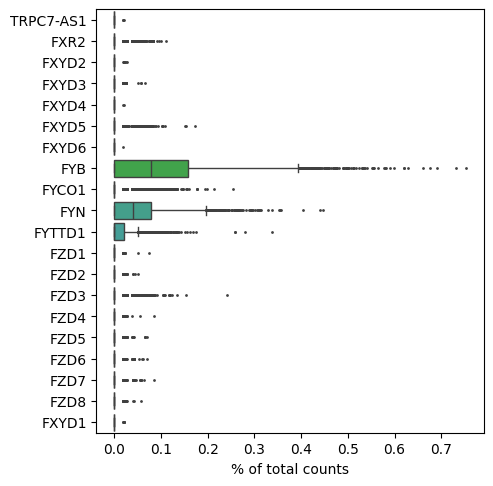

In [46]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [21]:
adata_raw = adata.copy()

In [ ]:
# Count the number of cells for each value in the 'organ_ontology_label' column
cell_counts = adata.obs['organ__ontology_label'].value_counts()
print(cell_counts)

organ__ontology_label
midgut region of duodenum     14691
foregut region of duodenum     8027
jejunum                        3838
Name: count, dtype: int64


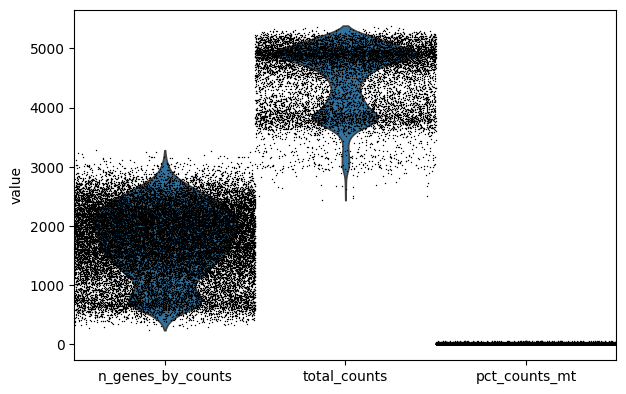

In [22]:
# Boolean mitochondrial gene identification
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Visualize detected counts, total expression and % of mitochondrial genes per cell
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.5)

Note:
- `n_genes_by_counts` =  number of genes with at least 1 count in a cell, calculated for all cells
- `total_counts` = sum of counts for a gene
- `pct_counts_mt` = proportion of total counts for a cell which are mitochondrial

The distribution of both `n_genes_by_counts` and `total_counts` is similar, at different scales. The former demonstrates unique genes being expressed/cell, while the later demonstrates total gene counts/cell.

In [23]:
# Filter cells
adata_filtered = adata[adata.obs.n_genes_by_counts > 250, :]
adata_filtered = adata[adata.obs.total_counts <= 50000, :]
adata_filtered = adata[adata.obs.pct_counts_mt < 50, :] # Keeping % mito super generous

In [24]:
cell_counts_filtered = adata_filtered.obs['organ__ontology_label'].value_counts()
print(cell_counts_filtered)

organ__ontology_label
midgut region of duodenum     4608
foregut region of duodenum    4215
jejunum                       2213
Name: count, dtype: int64


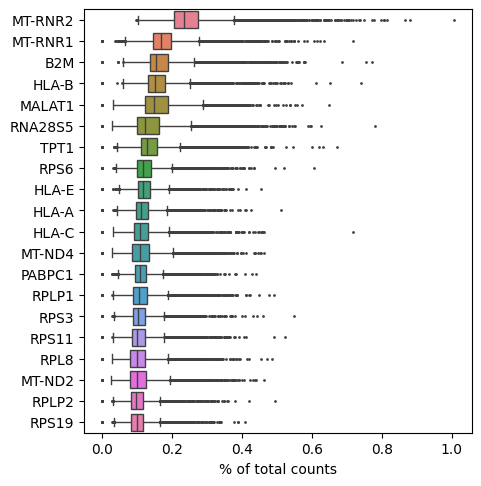

In [47]:
sc.pl.highest_expr_genes(adata_filtered, n_top=20)


In [25]:
# Normalize total counts and log transform
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
sc.pp.log1p(adata_filtered)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


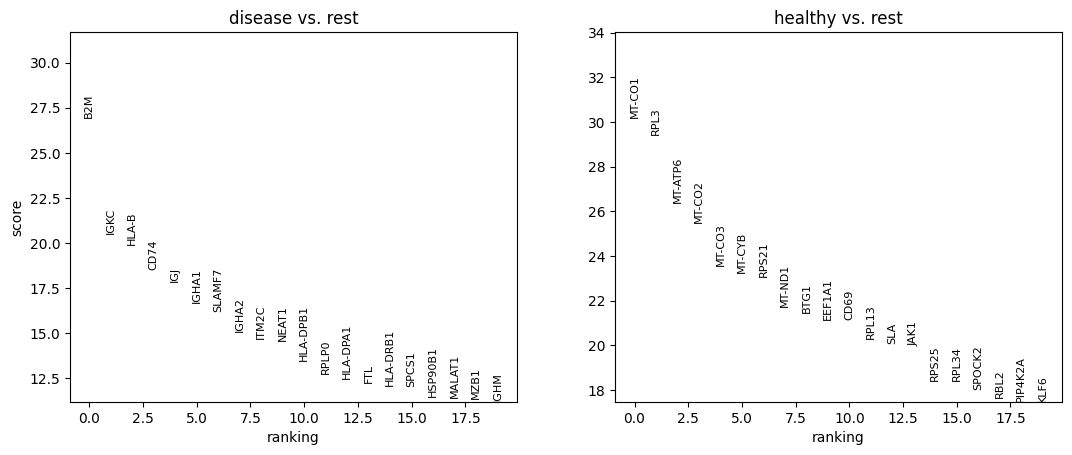

In [26]:
# Perform differential expression analysis
sc.tl.rank_genes_groups(adata_filtered, groupby='condition', method='wilcoxon')

# Plot top DEGs
sc.pl.rank_genes_groups(adata_filtered, n_genes=20, sharey=False)

The plot on the left demonstrates genes that are signifcantly upregulaed in the disease samples, while the one on the right demonstrates genes that are signficantly upregulated in the healthy samples.

In [27]:
# Get top DEGs for disease
top_disease_genes = adata_filtered.uns['rank_genes_groups']['names']['disease'][:500]  # Adjust the number as needed

# Subset adata to include only top disease-specific genes
adata_disease = adata_filtered[:, adata_filtered.var.index.isin(top_disease_genes)]

Now let's find highly variable genes within disease-specific genes. This will help remove noise before training our model, but only including the disease-specific genes with the highest variance.

In [28]:
# Subset to disease samples only
adata_disease_subset = adata_disease[adata_disease.obs['condition'] == 'disease', :]

# Find highly variable genes within disease samples
sc.pp.highly_variable_genes(adata_disease_subset, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Subset to retain only highly variable disease-specific genes
adata_disease = adata_disease_subset[:, adata_disease_subset.var['highly_variable']]


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [48]:
adata_disease.obs

,biosample_id,donor_id,species,species__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,sex,cell_subset,condition,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
NAME,,,,,,,,,,,,,,,,,
TCGAAACGTCAG_1_1_1_1_1_1_1_1_1_1_1_1_1,EE_HIV_1B,EE_HIV_1,NCBITaxon_9606,Homo sapiens,MONDO_0004335,digestive system disorder,UBERON_0003286,foregut region of duodenum,EFO_0008919,Seq-Well,male,T_CD8_IFI44_IFIT1,disease,2266,4396.0,428.0,9.736124
CCAGACACGCCA_1_1_1_1_1_1_1_1_1_1_1_1_1,EE_HIV_1B,EE_HIV_1,NCBITaxon_9606,Homo sapiens,MONDO_0004335,digestive system disorder,UBERON_0003286,foregut region of duodenum,EFO_0008919,Seq-Well,male,T_CD8_IFI44_IFIT1,disease,2678,5181.0,561.0,10.828025
AATCCTTGGTCC_1_1_1_1_1_1_1_1_1_1_1_1_1,EE_HIV_1B,EE_HIV_1,NCBITaxon_9606,Homo sapiens,MONDO_0004335,digestive system disorder,UBERON_0003286,foregut region of duodenum,EFO_0008919,Seq-Well,male,T_CD8_IFI44_IFIT1,disease,2737,5104.0,235.0,4.604232
TCTCGACGGATG_1_1_1_1_1_1_1_1_1_1_1_1_1,EE_HIV_1B,EE_HIV_1,NCBITaxon_9606,Homo sapiens,MONDO_0004335,digestive system disorder,UBERON_0003286,foregut region of duodenum,EFO_0008919,Seq-Well,male,T_MT,disease,1898,5155.0,2324.0,45.082444
TGCCCGCAATCT_1_1_1_1_1_1_1_1_1_1_1_1_1,EE_HIV_1B,EE_HIV_1,NCBITaxon_9606,Homo sapiens,MONDO_0004335,digestive system disorder,UBERON_0003286,foregut region of duodenum,EFO_0008919,Seq-Well,male,T_CD8_IFI44_IFIT1,disease,2535,5134.0,550.0,10.712894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGACTAGATCCT_1_1,EE_HIV_3J,EE_HIV_3,NCBITaxon_9606,Homo sapiens,MONDO_0004335,digestive system disorder,UBERON_0002115,jejunum,EFO_0008919,Seq-Well,male,Plasma_cells,disease,1505,4892.0,210.0,4.292723
AATAGATTGCTA_1_1,EE_HIV_3J,EE_HIV_3,NCBITaxon_9606,Homo sapiens,MONDO_0004335,digestive system disorder,UBERON_0002115,jejunum,EFO_0008919,Seq-Well,male,Plasma_cells,disease,1471,4631.0,330.0,7.125891
TGCGCAGGAAAC_1_1,EE_HIV_3J,EE_HIV_3,NCBITaxon_9606,Homo sapiens,MONDO_0004335,digestive system disorder,UBERON_0002115,jejunum,EFO_0008919,Seq-Well,male,Plasma_cells,disease,1728,4744.0,117.0,2.466273


In [49]:
cell_counts_disease = adata_filtered.obs['condition'].value_counts()
print(cell_counts_disease)

condition
disease    9955
healthy    1081
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


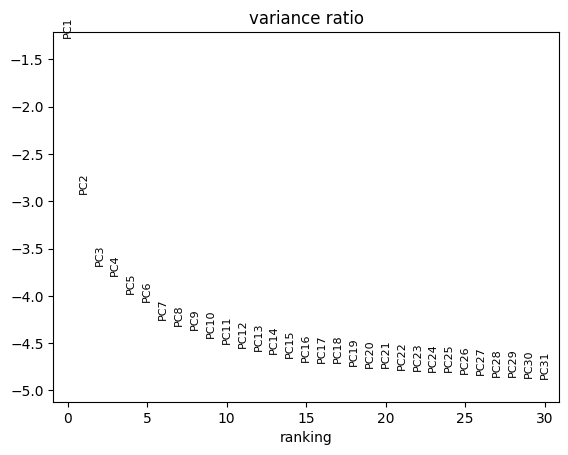

In [29]:
# Scale the data
sc.pp.scale(adata_disease, max_value=10)


# Perform PCA (dimensionality reduction)
sc.tl.pca(adata_disease, svd_solver='arpack')

# Visualize PCs
sc.pl.pca_variance_ratio(adata_disease, log=True)

In [30]:
# Save the principal components as a new adata attribute
adata_disease.obsm['X_pca'] = adata_disease.obsm['X_pca'][:, :30]  # Keep the top 30 components

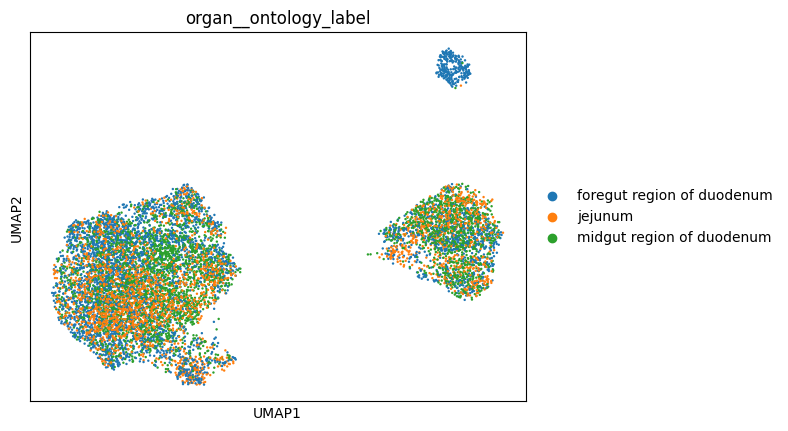

In [31]:
# Compute neighborhood graph
sc.pp.neighbors(adata_disease, n_pcs=23)

# Cluster the cells
sc.tl.umap(adata_disease, n_components=2)

# Visualize clusters
sc.pl.umap(adata_disease, color='organ__ontology_label')


Now that we've processed our data, let's get on to the machine learning!

We'll need to create labels for our supervised learning model. For this, prior biological knowledge is necessary. So in our case, we'll use a publicly accessible dataset from [Open Targets](https://platform.opentargets.org/downloads/data) containing druggable targets and their associated metadata, to classify genes of interest in our EE scRNA-seq data as potential drug targets.

In [32]:
target_data = pd.read_csv(
    "/content/drive/MyDrive/Genspace/SCP1307/targets/merged-data",
    quotechar='"',  # Specifies that double quotes enclose text
    skipinitialspace=True,  # Skip spaces after delimiters
    engine="python",  # Use Python engine to better handle irregularities
    on_bad_lines="skip"  # Skip problematic rows automatically
)

print(target_data.head())

                id approvedSymbol         biotype  \
0  ENSG00000000971            CFH  protein_coding   
1  ENSG00000007001           UPP2  protein_coding   
2  ENSG00000009694          TENM1  protein_coding   
3  ENSG00000011009         LYPLA2  protein_coding   
4  ENSG00000019582           CD74  protein_coding   

                                       transcriptIds  \
0  ['ENST00000359637' 'ENST00000695984' 'ENST0000...   
1  ['ENST00000605860' 'ENST00000460456' 'ENST0000...   
2  ['ENST00000422452' 'ENST00000371130' 'ENST0000...   
3  ['ENST00000374503' 'ENST00000374501' 'ENST0000...   
4  ['ENST00000518797' 'ENST00000523836' 'ENST0000...   

                                 canonicalTranscript  \
0  {'id': 'ENST00000367429', 'chromosome': '1', '...   
1  {'id': 'ENST00000005756', 'chromosome': '2', '...   
2  {'id': 'ENST00000422452', 'chromosome': 'X', '...   
3  {'id': 'ENST00000374514', 'chromosome': '1', '...   
4  {'id': 'ENST00000009530', 'chromosome': '5', '...   

       

In [33]:
adata_disease.var

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
AC096579.7,False,2008,1.172315,92.438620,31132.0,True,1.982855,4.127606,2.299103,0.561546,1.272065
AL928768.3,False,1638,0.232791,93.831902,6182.0,True,0.795876,2.862816,3.960377,0.289746,0.736169
ALCAM,False,4098,0.215017,84.568459,5710.0,True,0.264782,1.430680,0.615715,0.129725,0.411769
ALDH1L2,False,877,0.055656,96.697545,1478.0,True,0.251933,1.618167,1.362800,0.113319,0.403317
AMPD1,False,1224,0.115078,95.390872,3056.0,True,0.483083,2.135597,1.788758,0.194221,0.568216
...,...,...,...,...,...,...,...,...,...,...,...
TNFRSF17,False,1915,0.152094,92.788824,4039.0,True,0.599057,1.695308,0.781619,0.291208,0.645693
TP53INP1,False,4276,0.270749,83.898177,7190.0,True,0.757338,1.685331,0.649084,0.425064,0.708169
TRGC1,False,3697,0.356530,86.078476,9468.0,True,1.068939,2.093963,0.714352,0.561918,0.881413
TRGC2,False,5532,0.620236,79.168549,16471.0,True,1.431001,2.088961,0.889516,0.865101,1.018676


In [34]:
# Extract the column containing gene names from target_data
target_genes = target_data['approvedSymbol'].unique()

# Add a new column 'is_target' to adata.var
adata_disease.var['is_target'] = adata_disease.var.index.isin(target_genes).astype(int)

# Verify the integration and labels
print(adata_disease.var.head())

               mt  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
AC096579.7  False               2008     1.172315              92.438620   
AL928768.3  False               1638     0.232791              93.831902   
ALCAM       False               4098     0.215017              84.568459   
ALDH1L2     False                877     0.055656              96.697545   
AMPD1       False               1224     0.115078              95.390872   

            total_counts  highly_variable     means  dispersions  \
AC096579.7       31132.0             True  1.982855     4.127606   
AL928768.3        6182.0             True  0.795876     2.862816   
ALCAM             5710.0             True  0.264782     1.430680   
ALDH1L2           1478.0             True  0.251933     1.618167   
AMPD1             3056.0             True  0.483083     2.135597   

            dispersions_norm      mean       std  is_target  
AC096579.7          2.299103  0.561546  1.272065          0  
AL928768.3

In [50]:
na_columns = adata_disease.var.isna().any()
print(na_columns)

mt                       False
n_cells_by_counts        False
mean_counts              False
pct_dropout_by_counts    False
total_counts             False
highly_variable          False
means                    False
dispersions              False
dispersions_norm         False
mean                     False
std                      False
is_target                False
dtype: bool


Now that we've used the drug-target information to label druggable targets in our data appropriately, let's prepare our features and labels for machine learning.

Note: The dimensions of `adata_filtered.obsm['X_pca']` need to align with those of `adata.var['is_target'].`

- adata.obsm['X_pca'] is a matrix with dimensions (n_cells, n_pcs), where n_cells is the number of cells and n_pcs is the number of principal components.
- adata.var['is_target'] is a vector with length n_genes, representing annotations for genes.

In [35]:
# Features: Highly variable disease-specific genes (to minimize noise)
X = adata_disease.X.T

# Labels: Gene targets
y = adata_disease.var['is_target'].values


In [36]:
print(f"Features (X): {X.shape}")
print(f"Labels (y): {y.shape}")


Features (X): (103, 9955)
Labels (y): (103,)


:Now to build a Random Forest Classifier. This algorithm uses Decision Trees to classify data into binary categories. In our case, it will predict whether a gene is druggable (a target) or not.

We'll evaluate our model using appropriate metrics for classification tasks since your labels (y) are binary (1 for target, 0 for non-target). Common metrics include:
- Accuracy
- Precision
- Recall
- F-1 score (useful for imbalanced datasets)
- ROC-AUC

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
clf = RandomForestClassifier(random_state=42) # Instantiate
clf.fit(X_train, y_train) # Train

# Predict the test labels
y_pred = clf.predict(X_test)

# Predict probabilities for ROC-AUC or threshold adjustments
y_prob = clf.predict_proba(X_test)[:, 1]


In [40]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy: 0.86
Precision: 0.00
Recall: 0.00
F1-Score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC-AUC: 0.62


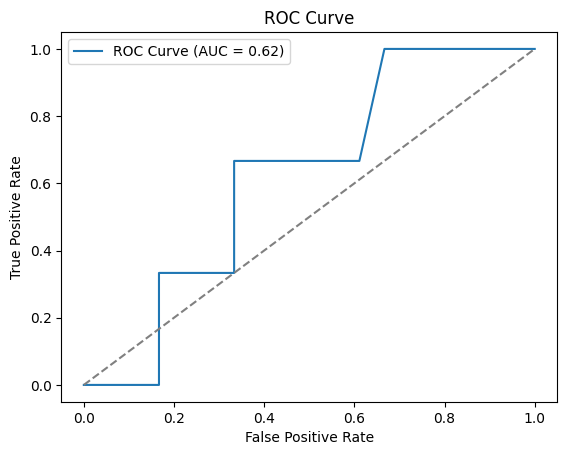

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc_auc:.2f}")

# Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [43]:
import numpy as np

# Extract feature importances
importances = clf.feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Print top 10 important features
print("Top 10 Important Features:")
for i in range(10):
    print(f"Feature {indices[i]}: Importance {importances[indices[i]]:.4f}")


Top 10 Important Features:
Feature 7309: Importance 0.0184
Feature 8476: Importance 0.0162
Feature 9582: Importance 0.0142
Feature 9484: Importance 0.0091
Feature 8275: Importance 0.0088
Feature 7929: Importance 0.0086
Feature 7443: Importance 0.0078
Feature 8517: Importance 0.0074
Feature 8866: Importance 0.0072
Feature 8930: Importance 0.0069


In [51]:
# Extract gene names
gene_names = adata_disease.var.index.tolist()


In [54]:
# Map feature indices to gene names
top_features = [7309, 8476, 9582, 9484, 8275, 7929, 7443, 8517, 8866, 8930]

# Map indices to gene names
feature_names = adata.var.index[top_features]

# Print the results
for idx, gene in zip(top_features, feature_names):
    print(f"Feature {idx}: {gene}")

Feature 7309: GLMN
Feature 8476: IL17RA
Feature 9582: LINC00598
Feature 9484: LINC00106
Feature 8275: HYAL2
Feature 7929: HID1
Feature 7443: GPATCH1
Feature 8517: IL7
Feature 8866: KCNJ12
Feature 8930: KCTD7


The importance score of a feature measures how much that feature (gene) contributed to the predictions made by the model.

In [45]:
# Get indices of genes predicted as targets
predicted_targets_indices = np.where(y_pred == 1)[0]

# Map indices to gene names
predicted_targets = adata_disease.var.index[predicted_targets_indices]

print(f"Predicted Drug Targets: {predicted_targets}")

Predicted Drug Targets: Index([], dtype='object')


In conclusion, in this case, ML might seem unnecessary because we already have the ground truth (the known drug targets) and could base our conclusions on that alone.

But ML adds value when you want to go beyond your labeled data; for example, to discover novel targets not included in the list of known targets.

Also, instead of manually inspecting thousands of genes, ML can systematically rank or classify genes based on their likelihood of being drug targets. This is useful for massive datasets will millions and billions of features.

Use cases for ML in this project include:

1. Rank Novel Drug Targets:
Predict which unlabeled genes have a high likelihood of being drug targets.
Sort and rank genes for prioritization based on their model-predicted probabilities.

2. Feature Importance Analysis:
Use ML models (e.g., Random Forest) to identify which features (e.g., expression variability, disease specificity) are most important for predicting drug targets.


3. Handle Data Noise:
scRNA-seq data is noisy, and manual methods might miss subtle patterns. ML can help filter noise and identify robust patterns.

4. Integrate Multi-Omics Data:
If you have additional data types (e.g., protein-protein interactions or genetic variants), ML models can integrate them with expression data to improve predictions